## Import Library & Set Up

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import math
import os
import time
from roboflow import Roboflow
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [9]:
from roboflow import Roboflow
rf = Roboflow(api_key="ejFkGPgDGCQYas0cD5DS")
project = rf.workspace("fpkkgunakanhelmdataset").project("dataset_helm_classification-9wb1c")
version = project.version(2)
dataset = version.download("yolov8")
                

loading Roboflow workspace...
loading Roboflow project...


In [6]:
from roboflow import Roboflow
rf = Roboflow(api_key="ejFkGPgDGCQYas0cD5DS")
project = rf.workspace("fpkkgunakanhelmdataset").project("dataset_helm_testing-jbyxm")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


## Training

In [2]:
model = YOLO("yolov8n.pt")
data_path = r"C:\Users\Royan\Documents\Semester 3\komputcerdas\FP-KK-Gunakan_Helm\Dataset_Helm_Classification-2\data.yaml"
model.train(
    data=data_path,
    epochs=100,         # Nano butuh waktu belajar lebih banyak biar pinter (Default 50 kurang)
    imgsz=640,          # Tetap 640 agar FPS ngebut (sesuai proposal)
    batch=-1,           # AutoBatch (Biar GPU kepakai maksimal)
    patience=25,        # Kesabaran ditambah dikit
    
    # --- Tuning Augmentasi (Resep Kebal Noise CCTV) ---
    # Ini memaksa Nano belajar "konsep" helm, bukan hafalan pixel
    degrees=10.0,       # Putar gambar +/- 10 derajat (motor belok/miring)
    scale=0.6,          # Zoom in/out random (60%) -> SANGAT PENTING buat objek jauh
    shear=2.0,          # Sedikit miringkan perspektif (simulasi sudut pandang CCTV)
    
    # Tuning Warna (Biar ga bingung siang/malam/mendung)
    hsv_h=0.015,        
    hsv_s=0.7,          
    hsv_v=0.4,          
    
    # Teknik Khusus Objek Kecil
    mosaic=1.0,         # Wajib 1.0. Ini menggabungkan 4 gambar jadi 1, memaksa model lihat objek kecil.
    mixup=0.1,          # (Optional) Mencampur 2 gambar transparan. Bantu kurangi salah deteksi.
    
    # Hardware
    device=0,           
    workers=4,          
    project="FP_Training",
    name="YOLOv8n_Tuned_Final"
)

Ultralytics 8.3.233  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\Royan\Documents\Semester 3\komputcerdas\FP-KK-Gunakan_Helm\Dataset_Helm_Classification-2\data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=YOLOv8n_Tuned_Final2, nbs=64, nms

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002080A284CD0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

## Frame Extraction for video testing

In [2]:
# ==========================================
# KONFIGURASI
# ==========================================
VIDEO_FOLDER = r"test"
# Folder untuk menyimpan video yang sudah di-resize (biar koordinat konsisten)
STD_VIDEO_FOLDER = r"test/standardized_videos"
# Folder untuk menyimpan frame gambar (untuk anotasi)
OUTPUT_FRAME_FOLDER = r"test/frames_video_test"

# Resolusi Standar (Misal HD 720p) -> Koordinat di CSV nanti mengacu ke ukuran ini!
TARGET_WIDTH = 1280
TARGET_HEIGHT = 720

# Buat folder jika belum ada
if not os.path.exists(STD_VIDEO_FOLDER): os.makedirs(STD_VIDEO_FOLDER)
if not os.path.exists(OUTPUT_FRAME_FOLDER): os.makedirs(OUTPUT_FRAME_FOLDER)

print("=== PROGRAM STANDARISASI & EKSTRAK FRAME ===")
print(f"Target Resolusi: {TARGET_WIDTH}x{TARGET_HEIGHT}\n")

# Loop semua file di folder test
for vid_name in os.listdir(VIDEO_FOLDER):
    # Skip jika bukan file video atau jika itu folder
    if not vid_name.endswith(('.mp4', '.avi', '.mov')): continue
    
    full_path = os.path.join(VIDEO_FOLDER, vid_name)
    
    # --- INTERAKSI PENGGUNA ---
    print(f"------------------------------------------------")
    print(f"Ditemukan video: {vid_name}")
    
    # Cek apakah video ini sudah pernah distandarisasi sebelumnya?
    std_save_path = os.path.join(STD_VIDEO_FOLDER, f"std_{vid_name}")
    if os.path.exists(std_save_path):
        print(f"[INFO] Video versi standar sudah ada: std_{vid_name}")
    
    confirm = input(f"Mau standarisasi & ekstrak '{vid_name}'? (y/n): ").strip().lower()
    
    if confirm != 'y':
        print("Skipped.")
        continue
    
    print(f"Memproses {vid_name}...")
    
    cap = cv2.VideoCapture(full_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    if fps == 0: fps = 30 # Fallback jika error baca FPS
    
    # Setup Video Writer untuk menyimpan hasil resize (Standardized Video)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(std_save_path, fourcc, fps, (TARGET_WIDTH, TARGET_HEIGHT))
    
    frame_count = 0
    saved_frames_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret: break
        
        frame_count += 1
        
        # 1. RESIZE FRAME (STANDARISASI)
        # Kita resize dulu frame-nya sebelum disimpan ke video baru atau diekstrak
        frame_resized = cv2.resize(frame, (TARGET_WIDTH, TARGET_HEIGHT), interpolation=cv2.INTER_AREA)
        
        # 2. SIMPAN KE FILE VIDEO BARU (STD)
        out.write(frame_resized)
        
        # 3. EKSTRAK FRAME PER DETIK (Untuk Anotasi)
        if frame_count % fps == 0:
            # Simpan gambar dari frame yang SUDAH DI-RESIZE
            # Nama file mengandung 'std_' agar Anda tahu ini dari video standar
            save_name = f"std_{vid_name}_frame_{frame_count}.jpg"
            cv2.imwrite(os.path.join(OUTPUT_FRAME_FOLDER, save_name), frame_resized)
            saved_frames_count += 1
            
    cap.release()
    out.release()
    print(f"✅ Selesai! Video standar tersimpan di: {STD_VIDEO_FOLDER}")
    print(f"📸 {saved_frames_count} Frame tersimpan di: {OUTPUT_FRAME_FOLDER}")

print("\n------------------------------------------------")
print("Semua proses selesai.")
print("PENTING: Saat mengisi CSV Ground Truth, pastikan video yang Anda tulis")
print("adalah nama video yang ada 'std_' di depannya (video hasil resize).")

=== PROGRAM STANDARISASI & EKSTRAK FRAME ===
Target Resolusi: 1280x720

------------------------------------------------
Ditemukan video: 14813939_1080_1920_30fps.mp4
[INFO] Video versi standar sudah ada: std_14813939_1080_1920_30fps.mp4
Skipped.
------------------------------------------------
Ditemukan video: 14813946_1080_1920_30fps.mp4
[INFO] Video versi standar sudah ada: std_14813946_1080_1920_30fps.mp4
Skipped.
------------------------------------------------
Ditemukan video: 5210841-uhd_3840_2160_30fps.mp4
[INFO] Video versi standar sudah ada: std_5210841-uhd_3840_2160_30fps.mp4
Skipped.
------------------------------------------------
Ditemukan video: VID_20251129_140711.mp4
[INFO] Video versi standar sudah ada: std_VID_20251129_140711.mp4
Skipped.
------------------------------------------------
Ditemukan video: VID_20251201_155431.mp4
Memproses VID_20251201_155431.mp4...
✅ Selesai! Video standar tersimpan di: test/standardized_videos
📸 8 Frame tersimpan di: test/frames_video

## Ground Truth Video Testing

In [11]:
import os
import csv
import yaml
import re # Tambahkan library Regex

# ==========================================
# KONFIGURASI (UBAH DISINI)
# ==========================================
ROBOFLOW_LABELS_FOLDER = r"Dataset_Helm_Testing-1\train\labels"
DATA_YAML_FILE = r"Dataset_Helm_Testing-1\data.yaml" 
OUTPUT_CSV = "ground_truth.csv"
IMG_WIDTH = 1280
IMG_HEIGHT = 720

LABEL_TRANSLATOR = {
    'Helmet': 'PAKAI HELM',
    'helmet': 'PAKAI HELM',
    'No_helmet': 'TIDAK PAKAI HELM',
    'no_helmet': 'TIDAK PAKAI HELM',
    'No Helmet': 'TIDAK PAKAI HELM',
    'head': 'TIDAK PAKAI HELM',
    'Motor': 'MOTOR',
    'motor': 'MOTOR',
    'motorcycle': 'MOTOR',
    'motorbike': 'MOTOR'
}

def load_class_names(yaml_path):
    if not os.path.exists(yaml_path):
        print(f"ERROR: File {yaml_path} tidak ditemukan.")
        return {}
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    names = data.get('names', [])
    id_map = {}
    if isinstance(names, list):
        for idx, name in enumerate(names): id_map[idx] = name
    elif isinstance(names, dict):
        for idx, name in names.items(): id_map[int(idx)] = name
    print(f"[INFO] Mapping Kelas dari YAML: {id_map}")
    return id_map

def yolo_to_pixel(x_center, y_center, w, h, img_w, img_h):
    x1 = int((x_center - w / 2) * img_w)
    y1 = int((y_center - h / 2) * img_h)
    x2 = int((x_center + w / 2) * img_w)
    y2 = int((y_center + h / 2) * img_h)
    return x1, y1, x2, y2

def main():
    print("=== KONVERSI ROBOFLOW TXT KE CSV (REGEX FIXED) ===")
    
    if not os.path.exists(ROBOFLOW_LABELS_FOLDER):
        print(f"ERROR: Folder labels tidak ditemukan.")
        return

    id_to_name = load_class_names(DATA_YAML_FILE)
    csv_data = []
    txt_files = [f for f in os.listdir(ROBOFLOW_LABELS_FOLDER) if f.endswith('.txt')]
    
    print(f"Memproses {len(txt_files)} file anotasi...")

    # Regex Pattern untuk menangkap nama video dan nomor frame
    # Pattern ini mencari teks sebelum '_frame_', lalu angka setelahnya
    # Contoh target: "std_video1.mp4" dan "120"
    pattern = re.compile(r"(.+)_frame_(\d+)")

    for txt_file in txt_files:
        try:
            # 1. Bersihkan nama file dari suffix aneh Roboflow (_jpg.rf.xxxx.txt)
            # Biasanya Roboflow nambahin '_jpg.rf.blablabla.txt' di belakang
            clean_name = txt_file.split('_jpg')[0] # Ambil bagian depan sebelum _jpg
            
            # Jika formatnya beda (misal .jpeg), coba split by .rf
            if clean_name == txt_file: 
                clean_name = txt_file.split('.rf.')[0]

            # 2. Cari pola nama_video + frame_number
            match = pattern.search(clean_name)
            
            if match:
                video_part = match.group(1) # std_video.mp4
                frame_num = int(match.group(2)) # 120
                
                # Normalisasi ekstensi file (Roboflow suka ganti titik jadi _)
                # Ubah _mp4 di akhir jadi .mp4
                if video_part.endswith("_mp4"):
                    video_name = video_part[:-4] + ".mp4"
                elif video_part.endswith("_avi"):
                    video_name = video_part[:-4] + ".avi"
                else:
                    video_name = video_part
            else:
                print(f"[SKIP] Pola nama file tidak dikenali: {txt_file}")
                continue

        except Exception as e:
            print(f"[SKIP] Error parsing {txt_file}: {e}")
            continue

        # Baca Isi File TXT
        file_path = os.path.join(ROBOFLOW_LABELS_FOLDER, txt_file)
        with open(file_path, 'r') as f:
            lines = f.readlines()
            
            for line in lines:
                data = line.strip().split()
                if len(data) < 5: continue
                
                cls_id = int(data[0])
                nx, ny, nw, nh = map(float, data[1:5])
                
                x1, y1, x2, y2 = yolo_to_pixel(nx, ny, nw, nh, IMG_WIDTH, IMG_HEIGHT)
                
                raw_name = id_to_name.get(cls_id, "Unknown")
                final_label = LABEL_TRANSLATOR.get(raw_name, raw_name)
                
                csv_data.append([video_name, frame_num, x1, y1, x2, y2, final_label])

    # Tulis CSV
    with open(OUTPUT_CSV, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['filename_video', 'frame_nomor', 'x1', 'y1', 'x2', 'y2', 'label'])
        writer.writerows(csv_data)
        
    print(f"\n✅ SUKSES! {len(csv_data)} data tersimpan di '{OUTPUT_CSV}'")

if __name__ == "__main__":
    main()

=== KONVERSI ROBOFLOW TXT KE CSV (REGEX FIXED) ===
[INFO] Mapping Kelas dari YAML: {0: 'Helmet', 1: 'Motor', 2: 'No_helmet'}
Memproses 497 file anotasi...

✅ SUKSES! 1971 data tersimpan di 'ground_truth.csv'


In [ ]:
import cv2
import csv
import os
import sys
import threading

# ==========================================
# KONFIGURASI
# ==========================================
INPUT_CSV = "ground_truth.csv"           
OUTPUT_CSV = "ground_truth_speed_only.csv"
FRAME_FOLDER = r"test/frames_video_test"   
VIDEO_FOLDER = r"test/standardized_videos" 

# Resolusi Referensi (Sama dengan saat Standarisasi Video)
REF_W = 1280
REF_H = 720

# Lebar Tampilan di Layar (Biar muat di laptop)
DISPLAY_WIDTH = 480 

def resize_for_display(image, target_width):
    if image is None: return None
    h, w = image.shape[:2]
    scale = target_width / w
    return cv2.resize(image, (target_width, int(h * scale)))

def draw_fancy_box(img, box, color, label):
    x1, y1, x2, y2 = box
    # Gambar kotak tebal
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
    # Gambar background label biar teks terbaca
    label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
    cv2.rectangle(img, (x1, y1 - 25), (x1 + label_size[0], y1), color, -1)
    # Teks Label
    cv2.putText(img, label, (x1, y1 - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

def main():
    if not os.path.exists(INPUT_CSV):
        print(f"Error: {INPUT_CSV} tidak ditemukan!")
        return

    processed_count = 0
    if os.path.exists(OUTPUT_CSV):
        with open(OUTPUT_CSV, 'r') as f:
            reader = csv.reader(f)
            rows = list(reader)
            if len(rows) > 0:
                processed_count = len(rows) - 1 
                print(f"--> Resume: {processed_count} data sudah ada.")

    with open(INPUT_CSV, 'r') as f:
        reader = csv.reader(f)
        all_rows = list(reader)
        header = all_rows[0]
        data_rows = all_rows[1:]

    if processed_count == 0:
        new_header = header + ['speed_ground_truth']
        with open(OUTPUT_CSV, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(new_header)
    
    total_data = len(data_rows)
    print(f"Total Data: {total_data}")
    print("CARA PAKAI: Ketik angka (0-100) di terminal -> Enter.")

    for i in range(processed_count, total_data):
        row = data_rows[i]
        
        video_name = row[0]
        frame_num = int(row[1])
        x1, y1, x2, y2 = int(row[2]), int(row[3]), int(row[4]), int(row[5])
        label_helm = row[6]

        img_filename = f"{video_name}_frame_{frame_num}.jpg"
        img_path = os.path.join(FRAME_FOLDER, img_filename)
        vid_path = os.path.join(VIDEO_FOLDER, video_name)
        
        if not os.path.exists(img_path) or not os.path.exists(vid_path):
            print(f"[SKIP] File hilang: {img_filename}")
            with open(OUTPUT_CSV, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(row + ["SKIP"]) 
            continue

        # 1. LOAD & PREPARE GAMBAR (Pastikan ukuran sama dgn referensi)
        original_img = cv2.imread(img_path)
        # Resize ke 1280x720 biar koordinat CSV pas
        target_img = cv2.resize(original_img, (REF_W, REF_H))
        
        color = (0, 0, 255) if "TIDAK" in label_helm else (0, 255, 0)
        draw_fancy_box(target_img, (x1, y1, x2, y2), color, label_helm)
        
        # Info text
        cv2.putText(target_img, f"Data {i+1}/{total_data}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        display_target = resize_for_display(target_img, DISPLAY_WIDTH)

        # 2. SETUP VIDEO PLAYER
        cap = cv2.VideoCapture(vid_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        start_frame = max(0, frame_num - int(fps*2))
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        print(f"\n[{i+1}/{total_data}] Target: {label_helm}")

        # Input Threading
        input_container = {'val': None}
        def get_input():
            try:
                val = input(">>> Kecepatan: ")
                input_container['val'] = val
            except: pass

        t = threading.Thread(target=get_input)
        t.daemon = True
        t.start()

        while t.is_alive():
            ret, frame = cap.read()
            curr_pos = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
            
            if not ret or curr_pos > frame_num + int(fps*2):
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
                continue
            
            # RESIZE FRAME VIDEO KE REFERENSI DULU (Biar koordinat kotak pas)
            frame_std = cv2.resize(frame, (REF_W, REF_H))
            
            # Gambar kotak yang sama persis
            draw_fancy_box(frame_std, (x1, y1, x2, y2), color, "FOKUS DISINI")
            
            display_video = resize_for_display(frame_std, DISPLAY_WIDTH)
            
            cv2.imshow("1. FOTO (Static)", display_target)
            cv2.imshow("2. VIDEO (Motion)", display_video)
            
            if cv2.waitKey(30) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                sys.exit()

        cap.release()
        cv2.destroyAllWindows()
        
        raw_input = input_container['val']
        if raw_input and raw_input.lower() == 'q': sys.exit()
        
        try:
            speed_val = int(raw_input)
            print(f"   -> OK: {speed_val}")
            with open(OUTPUT_CSV, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(row + [speed_val])
        except:
            print("⚠️ Input Skip.")
            with open(OUTPUT_CSV, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(row + ["SKIP"])

    print("\n✅ SELESAI!")

if __name__ == "__main__":
    main()

--> Resume: 1968 data sudah ada.
Total Data: 1971
CARA PAKAI: Ketik angka (0-100) di terminal -> Enter.

[1969/1971] Target: PAKAI HELM
⚠️ Input Skip.

[1970/1971] Target: PAKAI HELM


## Yolo

In [ ]:
# ==========================================
# 1. KONFIGURASI
# ==========================================
VIDEO_FOLDER = r"test/standardized_videos"
MODEL_PATH = r"FP_Training/YOLOv8n_Tuned_Final2/weights/best.pt" 

# Output 1: Hasil Deteksi (Untuk hitung Akurasi nanti)
OUTPUT_PRED_CSV = "predictions_yolo.csv"

# Output 2: Hasil Performa (Untuk Grafik FPS & RAM)
OUTPUT_PERF_CSV = "performance_log.csv" 

# Parameter
CONF_THRESHOLD = 0.25    
HELMET_DIST_THRESHOLD = 250 
SPEED_MIN_THRESHOLD = 2.0 
PIXELS_PER_METER = 20  
FPS_CAMERA = 30        

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def get_memory_usage():
    """Mengambil pemakaian RAM program ini dalam Megabyte (MB)"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024 

def get_helmet_info(motor_box, all_yolo_boxes, class_names):
    mx1, my1, mx2, my2 = map(int, motor_box)
    mc = ((mx1+mx2)//2, (my1+my2)//2)
    final_status = "Unknown"
    head_box = None 
    min_dist = HELMET_DIST_THRESHOLD
    
    for box in all_yolo_boxes:
        cls_id = int(box.cls[0])
        label = class_names[cls_id]
        bx1, by1, bx2, by2 = map(int, box.xyxy[0])
        hc = ((bx1+bx2)//2, (by1+by2)//2)
        dist = math.dist(mc, hc)
        if dist < min_dist:
            if hc[1] < mc[1]: 
                min_dist = dist
                head_box = (bx1, by1, bx2, by2)
                if label in ['Helmet', 'helmet']: final_status = "PAKAI HELM"
                elif label in ['No_helmet', 'no_helmet']: final_status = "TIDAK PAKAI HELM"
    return final_status, head_box

def run_batch_prediction():
    print("=== PREDIKSI BATCH + PERFORMANCE MONITORING ===")
    
    if not os.path.exists(VIDEO_FOLDER):
        print(f"Error folder: {VIDEO_FOLDER}")
        return

    # Siapkan 2 File CSV
    f_pred = open(OUTPUT_PRED_CSV, 'w', newline='')
    writer_pred = csv.writer(f_pred)
    writer_pred.writerow(['filename_video', 'frame_nomor', 'x1', 'y1', 'x2', 'y2', 'label', 'speed_pred'])
    
    f_perf = open(OUTPUT_PERF_CSV, 'w', newline='')
    writer_perf = csv.writer(f_perf)
    writer_perf.writerow(['filename_video', 'avg_fps', 'max_memory_mb', 'total_time_sec'])

    print("Loading Model...")
    model = YOLO(MODEL_PATH)
    
    video_files = [f for f in os.listdir(VIDEO_FOLDER) if f.endswith(('.mp4', '.avi'))]
    print(f"Total Video: {len(video_files)}")

    for vid_name in video_files:
        full_path = os.path.join(VIDEO_FOLDER, vid_name)
        cap = cv2.VideoCapture(full_path)
        
        track_history = {}
        speed_history = {}
        frame_count = 0
        
        # --- VARIABLE MONITORING PER VIDEO ---
        start_time_video = time.time()
        fps_list = []
        memory_list = []
        
        print(f"--> Memproses: {vid_name}")

        while True:
            iter_start = time.time() # Jam mulai frame ini
            
            ret, frame = cap.read()
            if not ret: break
            frame_count += 1

            # 1. Resize Wajib
            frame = cv2.resize(frame, (1280, 720)) 

            # 2. Tracking YOLO
            results = model.track(frame, persist=True, conf=CONF_THRESHOLD, verbose=False)[0]
            
            if results.boxes.id is not None:
                boxes = results.boxes.xyxy.cpu().numpy().astype(int)
                track_ids = results.boxes.id.cpu().numpy().astype(int)
                clss = results.boxes.cls.cpu().numpy().astype(int)
                
                for box, track_id, cls in zip(boxes, track_ids, clss):
                    label = model.names[cls]
                    
                    if label in ['Motor', 'motorcycle', 'motorbike']:
                        mx1, my1, mx2, my2 = box
                        status_txt, head_box = get_helmet_info(box, results.boxes, model.names)
                        
                        fx1, fy1, fx2, fy2 = mx1, my1, mx2, my2
                        if head_box is not None:
                            hx1, hy1, hx2, hy2 = head_box
                            fx1, fy1, fx2, fy2 = min(mx1, hx1), min(my1, hy1), max(mx2, hx2), max(my2, hy2)
                        
                        curr_center = ((fx1+fx2)//2, (fy1+fy2)//2)
                        speed_px = 0.0
                        if track_id in track_history:
                            dist = math.dist(track_history[track_id], curr_center)
                            if dist > SPEED_MIN_THRESHOLD: speed_px = dist
                        
                        track_history[track_id] = curr_center
                        
                        speed_kmh = (speed_px * FPS_CAMERA / PIXELS_PER_METER) * 3.6
                        save_label = status_txt if status_txt != "Unknown" else "MOTOR"
                        
                        # Simpan Data Prediksi
                        writer_pred.writerow([vid_name, frame_count, fx1, fy1, fx2, fy2, save_label, round(speed_kmh, 2)])

            # --- MONITORING (FPS & RAM) ---
            iter_end = time.time()
            proc_time = iter_end - iter_start
            
            # Hitung FPS instan
            current_fps = 1.0 / proc_time if proc_time > 0 else 0
            fps_list.append(current_fps)
            
            # Hitung RAM saat ini
            current_ram = get_memory_usage()
            memory_list.append(current_ram)
            
            # Display (Opsional - Matikan saat benchmark serius)
            cv2.imshow("Monitoring", cv2.resize(frame, (640, 360)))
            if cv2.waitKey(1) & 0xFF == ord('q'): break

        cap.release()
        
        # --- REKAP PER VIDEO ---
        total_time = time.time() - start_time_video
        avg_fps = np.mean(fps_list) if fps_list else 0
        max_ram = np.max(memory_list) if memory_list else 0
        
        print(f"    [DONE] FPS Rata-rata: {avg_fps:.1f} | Max RAM: {max_ram:.1f} MB")
        
        # Simpan Rapor Performa
        writer_perf.writerow([vid_name, round(avg_fps, 2), round(max_ram, 2), round(total_time, 2)])

    f_pred.close()
    f_perf.close()
    cv2.destroyAllWindows()
    print("\n✅ SELESAI! Cek file:")
    print(f"1. {OUTPUT_PRED_CSV} (Untuk Evaluasi Akurasi)")
    print(f"2. {OUTPUT_PERF_CSV} (Untuk Evaluasi Kecepatan Komputasi/FPS)")

if __name__ == "__main__":
    run_batch_prediction()

=== PREDIKSI BATCH + PERFORMANCE MONITORING ===
Loading Model...
Total Video: 39
--> Memproses: std_14813939_1080_1920_30fps.mp4
    [DONE] FPS Rata-rata: 31.6 | Max RAM: 1067.6 MB
--> Memproses: std_14813946_1080_1920_30fps.mp4
    [DONE] FPS Rata-rata: 27.1 | Max RAM: 1065.1 MB
--> Memproses: std_5210841-uhd_3840_2160_30fps.mp4
    [DONE] FPS Rata-rata: 31.4 | Max RAM: 1067.0 MB
--> Memproses: std_VID_20251129_140711.mp4
    [DONE] FPS Rata-rata: 28.5 | Max RAM: 1067.1 MB
--> Memproses: std_VID_20251201_155431.mp4
    [DONE] FPS Rata-rata: 28.7 | Max RAM: 1067.9 MB
--> Memproses: std_VID_20251201_155912.mp4
    [DONE] FPS Rata-rata: 29.0 | Max RAM: 1067.7 MB
--> Memproses: std_VID_20251201_155930.mp4
    [DONE] FPS Rata-rata: 25.3 | Max RAM: 1068.7 MB
--> Memproses: std_VID_20251201_155948.mp4
    [DONE] FPS Rata-rata: 27.6 | Max RAM: 1051.9 MB
--> Memproses: std_VID_20251201_160017.mp4
    [DONE] FPS Rata-rata: 28.6 | Max RAM: 1055.6 MB
--> Memproses: std_VID_20251201_160045.mp4
   

## Yolo Pso

In [23]:
# ==============================================================================
# 1. KONFIGURASI
# ==============================================================================
VIDEO_FOLDER = r"test/standardized_videos"
MODEL_PATH = r"FP_Training/YOLOv8n_Tuned_Final2/weights/best.pt" 

OUTPUT_PRED_CSV = "predictions_pso.csv"
OUTPUT_PERF_CSV = "performance_log_pso.csv" 

# --- KONVERSI SPEED ---
PIXELS_PER_METER = 20  
FPS_CAMERA = 30        

# --- SETTING DETEKSI ---
CONF_THRESHOLD = 0.25    
HELMET_DIST_THRESHOLD = 250

# --- SETTING PSO ---
PSO_N_PARTICLES = 20     
PSO_W, PSO_C1, PSO_C2 = 0.4, 0.8, 0.8
PSO_V_MAX = 10           
INIT_SPREAD = 0.2        

# --- SMOOTHING ---
SMOOTH_FACTOR_YOLO = 0.7 
SMOOTH_FACTOR_PSO  = 0.4 
SPEED_MIN_THRESHOLD = 2.0 

# ==============================================================================
# 2. HELPER FUNCTIONS
# ==============================================================================
def get_memory_usage():
    """Mengambil pemakaian RAM program ini dalam Megabyte (MB)"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024 

class MotorTracker:
    def __init__(self, track_id, bbox, frame):
        self.id = track_id
        self.bbox = bbox 
        self.prev_center = ((bbox[0]+bbox[2])//2, (bbox[1]+bbox[3])//2)
        self.speed_px = 0
        self.missing_frames = 0 
        
        self.target_hist = self.get_hist(frame, bbox)
        self.particles = self.init_particles(bbox)
        self.v = np.zeros_like(self.particles)
        self.p_best = self.particles.copy()
        self.g_best = self.particles[0]
        self.helmet_status = "Unknown"
        
    def get_hist(self, frame, bbox):
        x1, y1, x2, y2 = map(int, bbox)
        h, w, _ = frame.shape
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        roi = frame[y1:y2, x1:x2]
        if roi.size == 0: return None
        hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
        cv2.normalize(hist, hist)
        return hist.flatten()

    def init_particles(self, bbox, n=PSO_N_PARTICLES):
        particles = []
        x1, y1, x2, y2 = bbox
        w, h = x2-x1, y2-y1
        cx, cy = x1 + w/2, y1 + h/2
        spread_x = int(w * INIT_SPREAD)
        spread_y = int(h * INIT_SPREAD)
        for _ in range(n):
            dx = np.random.randint(-spread_x, spread_x)
            dy = np.random.randint(-spread_y, spread_y)
            pw, ph = w * np.random.uniform(0.95, 1.05), h * np.random.uniform(0.95, 1.05)
            particles.append([cx + dx - pw/2, cy + dy - ph/2, cx + dx + pw/2, cy + dy + ph/2])
        return np.array(particles, dtype=float)

    def fitness(self, frame, bbox):
        x1, y1, x2, y2 = map(int, bbox)
        h, w, _ = frame.shape
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        roi = frame[y1:y2, x1:x2]
        if roi.size == 0 or self.target_hist is None: return 0
        curr_hist = self.get_hist(frame, (x1, y1, x2, y2))
        return cv2.compareHist(self.target_hist, curr_hist, cv2.HISTCMP_CORREL) if curr_hist is not None else 0

    def update(self, frame, yolo_bbox=None):
        fits = [self.fitness(frame, p) for p in self.particles]
        best_idx = np.argmax(fits)
        if fits[best_idx] > self.fitness(frame, self.g_best): self.g_best = self.particles[best_idx]
        mask = np.array(fits) > np.array([self.fitness(frame, p) for p in self.p_best])
        self.p_best[mask] = self.particles[mask]
        
        r1, r2 = np.random.rand(PSO_N_PARTICLES, 4), np.random.rand(PSO_N_PARTICLES, 4)
        self.v = PSO_W * self.v + PSO_C1 * r1 * (self.p_best - self.particles) + PSO_C2 * r2 * (self.g_best - self.particles)
        self.v = np.clip(self.v, -PSO_V_MAX, PSO_V_MAX)
        self.particles += self.v

        if yolo_bbox is not None:
            self.bbox = SMOOTH_FACTOR_YOLO * np.array(yolo_bbox) + (1 - SMOOTH_FACTOR_YOLO) * np.array(self.bbox)
            self.missing_frames = 0
            # Reset logic omitted for brevity
        else:
            self.bbox = SMOOTH_FACTOR_PSO * np.array(self.g_best) + (1 - SMOOTH_FACTOR_PSO) * np.array(self.bbox)
            self.missing_frames += 1

        self.bbox = tuple(map(int, self.bbox))
        curr = ((self.bbox[0]+self.bbox[2])//2, (self.bbox[1]+self.bbox[3])//2)
        dist = math.dist(self.prev_center, curr)
        self.speed_px = dist if dist > SPEED_MIN_THRESHOLD else 0
        self.prev_center = curr

def match_detections_to_trackers(detections, trackers):
    matches, unmatched, used = [], [], set()
    for i, det in enumerate(detections):
        d_center = ((det[0]+det[2])//2, (det[1]+det[3])//2)
        best_idx, min_dist = -1, 100
        for j, trk in enumerate(trackers):
            if j in used: continue
            t_center = ((trk.bbox[0]+trk.bbox[2])//2, (trk.bbox[1]+trk.bbox[3])//2)
            dist = math.dist(d_center, t_center)
            if dist < min_dist: min_dist, best_idx = dist, j
        if best_idx != -1: matches.append((best_idx, i)); used.add(best_idx)
        else: unmatched.append(i)
    return matches, unmatched, used

def check_helmet_status(motor_box, all_yolo_boxes, class_names):
    mx1, my1, mx2, my2 = map(int, motor_box)
    mc = ((mx1+mx2)//2, (my1+my2)//2)
    status = "Unknown"
    min_dist = HELMET_DIST_THRESHOLD
    for box in all_yolo_boxes:
        cls = int(box.cls[0])
        label = class_names[cls]
        bx = map(int, box.xyxy[0])
        bx1, by1, bx2, by2 = bx
        hc = ((bx1+bx2)//2, (by1+by2)//2)
        dist = math.dist(mc, hc)
        if dist < min_dist and hc[1] < mc[1]:
            min_dist = dist
            if label in ['Helmet', 'helmet']: status = "PAKAI HELM"
            elif label in ['No_helmet', 'no_helmet']: status = "TIDAK PAKAI HELM"
    return status

# ==============================================================================
# 3. MAIN BATCH PROCESSOR (PSO)
# ==============================================================================
def run_batch_prediction_pso():
    print("=== PREDIKSI BATCH PSO + PERFORMA ===")
    
    if not os.path.exists(VIDEO_FOLDER): return

    f_pred = open(OUTPUT_PRED_CSV, 'w', newline='')
    writer_pred = csv.writer(f_pred)
    writer_pred.writerow(['filename_video', 'frame_nomor', 'x1', 'y1', 'x2', 'y2', 'label', 'speed_pred'])
    
    f_perf = open(OUTPUT_PERF_CSV, 'w', newline='')
    writer_perf = csv.writer(f_perf)
    writer_perf.writerow(['filename_video', 'avg_fps', 'max_memory_mb', 'total_time_sec'])
    
    print("Loading Model...")
    model = YOLO(MODEL_PATH)
    video_files = [f for f in os.listdir(VIDEO_FOLDER) if f.endswith(('.mp4', '.avi'))]

    for vid_name in video_files:
        cap = cv2.VideoCapture(os.path.join(VIDEO_FOLDER, vid_name))
        trackers = [] 
        next_id = 1
        frame_count = 0
        
        # Monitoring Vars
        start_time_video = time.time()
        fps_list = []
        memory_list = []
        
        print(f"--> Memproses PSO: {vid_name}")

        while True:
            iter_start = time.time()
            ret, frame = cap.read()
            if not ret: break
            frame_count += 1
            frame = cv2.resize(frame, (1280, 720))

            # YOLO Detection
            results = model(frame, conf=CONF_THRESHOLD, verbose=False)[0]
            motor_detections = []
            for r in results.boxes:
                if model.names[int(r.cls[0])] in ['Motor', 'motorcycle', 'motorbike']:
                    motor_detections.append(tuple(map(int, r.xyxy[0])))
            
            # PSO Matching
            matches, unmatched_dets, used_idxs = match_detections_to_trackers(motor_detections, trackers)
            
            # Update Trackers
            for t_idx, d_idx in matches:
                trackers[t_idx].update(frame, yolo_bbox=motor_detections[d_idx])
                s = check_helmet_status(motor_detections[d_idx], results.boxes, model.names)
                if s != "Unknown": trackers[t_idx].helmet_status = s

            for i in range(len(trackers)):
                if i not in used_idxs: trackers[i].update(frame, None)
            
            for d_idx in unmatched_dets:
                nt = MotorTracker(next_id, motor_detections[d_idx], frame)
                nt.helmet_status = check_helmet_status(motor_detections[d_idx], results.boxes, model.names)
                trackers.append(nt)
                next_id += 1
                
            trackers = [t for t in trackers if t.missing_frames < 30]

            # Write Data
            for t in trackers:
                kmh = (t.speed_px * FPS_CAMERA / PIXELS_PER_METER) * 3.6
                lbl = t.helmet_status if t.helmet_status != "Unknown" else "MOTOR"
                writer_pred.writerow([vid_name, frame_count, *t.bbox, lbl, round(kmh, 2)])

            # Monitoring
            iter_end = time.time()
            proc = iter_end - iter_start
            fps_list.append(1.0/proc if proc > 0 else 0)
            memory_list.append(get_memory_usage())
            
            # Display (Opsional)
            cv2.imshow("Batch PSO Monitoring", cv2.resize(frame, (640, 360)))
            if cv2.waitKey(1) & 0xFF == ord('q'): break

        cap.release()
        
        # Rekap Performa
        total_time = time.time() - start_time_video
        avg_fps = np.mean(fps_list) if fps_list else 0
        max_ram = np.max(memory_list) if memory_list else 0
        print(f"    [DONE] FPS: {avg_fps:.1f} | RAM: {max_ram:.1f} MB")
        writer_perf.writerow([vid_name, round(avg_fps, 2), round(max_ram, 2), round(total_time, 2)])

    f_pred.close()
    f_perf.close()
    cv2.destroyAllWindows()
    print("\n✅ SELESAI PSO!")

if __name__ == "__main__":
    run_batch_prediction_pso()

=== PREDIKSI BATCH PSO + PERFORMA ===
Loading Model...
--> Memproses PSO: std_14813939_1080_1920_30fps.mp4
    [DONE] FPS: 37.5 | RAM: 663.6 MB
--> Memproses PSO: std_14813946_1080_1920_30fps.mp4
    [DONE] FPS: 28.7 | RAM: 664.8 MB
--> Memproses PSO: std_5210841-uhd_3840_2160_30fps.mp4
    [DONE] FPS: 49.5 | RAM: 666.9 MB
--> Memproses PSO: std_VID_20251129_140711.mp4
    [DONE] FPS: 36.3 | RAM: 649.0 MB
--> Memproses PSO: std_VID_20251201_155431.mp4
    [DONE] FPS: 45.1 | RAM: 649.1 MB
--> Memproses PSO: std_VID_20251201_155912.mp4
    [DONE] FPS: 39.8 | RAM: 649.0 MB
--> Memproses PSO: std_VID_20251201_155930.mp4
    [DONE] FPS: 20.1 | RAM: 649.1 MB
--> Memproses PSO: std_VID_20251201_155948.mp4
    [DONE] FPS: 27.1 | RAM: 647.9 MB
--> Memproses PSO: std_VID_20251201_160017.mp4
    [DONE] FPS: 20.4 | RAM: 649.9 MB
--> Memproses PSO: std_VID_20251201_160045.mp4
    [DONE] FPS: 42.4 | RAM: 650.0 MB
--> Memproses PSO: std_VID_20251201_160105.mp4
    [DONE] FPS: 54.9 | RAM: 649.8 MB
-->

In [32]:
import cv2
import numpy as np
from ultralytics import YOLO
import math
import time
import os
import csv
import psutil

# ==============================================================================
# 1. KONFIGURASI
# ==============================================================================
VIDEO_FOLDER = r"test/standardized_videos"
MODEL_PATH = r"FP_Training/YOLOv8n_Tuned_Final2/weights/best.pt" 

# --- OUTPUT FILES (GANTI NAMA BIAR GAK NIMPA PSO) ---
OUTPUT_PRED_CSV = "predictions_gwo.csv"
OUTPUT_PERF_CSV = "performance_log_gwo.csv" 

# --- KONVERSI SPEED ---
PIXELS_PER_METER = 20  
FPS_CAMERA = 30        

# --- SETTING DETEKSI ---
CONF_THRESHOLD = 0.25    
HELMET_DIST_THRESHOLD = 250 

# --- SETTING GWO (GREY WOLF OPTIMIZER) ---
GWO_N_WOLVES = 20        # Jumlah serigala (populasi)
INIT_SPREAD = 0.2        # Sebaran awal

# --- SMOOTHING ---
SMOOTH_FACTOR_YOLO = 0.7 
SMOOTH_FACTOR_GWO  = 0.4 
SPEED_MIN_THRESHOLD = 2.0 

# ==============================================================================
# 2. HELPER FUNCTIONS
# ==============================================================================
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024 

class MotorTrackerGWO:
    def __init__(self, track_id, bbox, frame):
        self.id = track_id
        self.bbox = bbox 
        self.prev_center = ((bbox[0]+bbox[2])//2, (bbox[1]+bbox[3])//2)
        self.speed_px = 0
        self.missing_frames = 0 
        
        self.target_hist = self.get_hist(frame, bbox)
        self.wolves = self.init_wolves(bbox) # Populasi Serigala
        
        # Hierarchy GWO (Alpha, Beta, Delta)
        # Kita inisialisasi semuanya di posisi awal bbox
        self.alpha_pos = np.array(bbox, dtype=float)
        self.beta_pos  = np.array(bbox, dtype=float)
        self.delta_pos = np.array(bbox, dtype=float)
        
        self.alpha_score = -float("inf")
        self.beta_score  = -float("inf")
        self.delta_score = -float("inf")
        
        self.helmet_status = "Unknown"
        
    def get_hist(self, frame, bbox):
        # (Sama seperti sebelumnya)
        x1, y1, x2, y2 = map(int, bbox)
        h, w, _ = frame.shape
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        if x2<=x1 or y2<=y1: return None
        roi = frame[y1:y2, x1:x2]
        if roi.size == 0: return None
        hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
        cv2.normalize(hist, hist)
        return hist.flatten()

    def init_wolves(self, bbox, n=GWO_N_WOLVES):
        # (Sama seperti sebelumnya)
        wolves = []
        x1, y1, x2, y2 = bbox
        w, h = x2-x1, y2-y1
        cx, cy = x1 + w/2, y1 + h/2
        spread_x = int(w * INIT_SPREAD)
        spread_y = int(h * INIT_SPREAD)
        for _ in range(n):
            dx = np.random.randint(-spread_x, spread_x)
            dy = np.random.randint(-spread_y, spread_y)
            pw, ph = w * np.random.uniform(0.95, 1.05), h * np.random.uniform(0.95, 1.05)
            wolves.append([cx + dx - pw/2, cy + dy - ph/2, cx + dx + pw/2, cy + dy + ph/2])
        return np.array(wolves, dtype=float)

    def fitness(self, frame, bbox):
        # (Sama seperti sebelumnya)
        x1, y1, x2, y2 = map(int, bbox)
        h, w, _ = frame.shape
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        if x2<=x1 or y2<=y1: return 0
        roi = frame[y1:y2, x1:x2]
        if roi.size == 0 or self.target_hist is None: return 0
        curr_hist = self.get_hist(frame, (x1, y1, x2, y2))
        return cv2.compareHist(self.target_hist, curr_hist, cv2.HISTCMP_CORREL) if curr_hist is not None else 0

    def update(self, frame, yolo_bbox=None):
        # --- LOGIKA UPDATE GWO (YANG BENAR) ---
        h_img, w_img, _ = frame.shape

        # 1. Update Hierarchy (Cari Siapa Alpha, Beta, Delta)
        for i in range(len(self.wolves)):
            self.wolves[i] = np.clip(self.wolves[i], 0, [w_img, h_img, w_img, h_img])
            fit = self.fitness(frame, self.wolves[i])
            
            if fit > self.alpha_score:
                self.delta_score = self.beta_score; self.delta_pos = self.beta_pos.copy()
                self.beta_score = self.alpha_score; self.beta_pos = self.alpha_pos.copy()
                self.alpha_score = fit; self.alpha_pos = self.wolves[i].copy()
            elif fit > self.beta_score:
                self.delta_score = self.beta_score; self.delta_pos = self.beta_pos.copy()
                self.beta_score = fit; self.beta_pos = self.wolves[i].copy()
            elif fit > self.delta_score:
                self.delta_score = fit; self.delta_pos = self.wolves[i].copy()

        # 2. Gerakkan Serigala (Rumus Matematika GWO)
        a = 1.5 # Parameter linear menurun
        
        for i in range(len(self.wolves)):
            for j in range(4):
                r1, r2 = np.random.random(), np.random.random()
                A1, C1 = 2*a*r1 - a, 2*r2
                D_alpha = abs(C1 * self.alpha_pos[j] - self.wolves[i][j])
                X1 = self.alpha_pos[j] - A1 * D_alpha
                
                r1, r2 = np.random.random(), np.random.random()
                A2, C2 = 2*a*r1 - a, 2*r2
                D_beta = abs(C2 * self.beta_pos[j] - self.wolves[i][j])
                X2 = self.beta_pos[j] - A2 * D_beta
                
                r1, r2 = np.random.random(), np.random.random()
                A3, C3 = 2*a*r1 - a, 2*r2
                D_delta = abs(C3 * self.delta_pos[j] - self.wolves[i][j])
                X3 = self.delta_pos[j] - A3 * D_delta
                
                self.wolves[i][j] = (X1 + X2 + X3) / 3

        # 3. Correction
        if yolo_bbox is not None:
            self.bbox = SMOOTH_FACTOR_YOLO * np.array(yolo_bbox) + (1 - SMOOTH_FACTOR_YOLO) * np.array(self.bbox)
            self.alpha_pos = np.array(yolo_bbox, dtype=float) # Reset Alpha ke YOLO
            self.missing_frames = 0
        else:
            self.bbox = SMOOTH_FACTOR_GWO * self.alpha_pos + (1 - SMOOTH_FACTOR_GWO) * np.array(self.bbox)
            self.missing_frames += 1

        self.bbox = tuple(map(int, self.bbox))
        
        # 4. Speed Calc
        curr = ((self.bbox[0]+self.bbox[2])//2, (self.bbox[1]+self.bbox[3])//2)
        dist = math.dist(self.prev_center, curr)
        self.speed_px = dist if dist > SPEED_MIN_THRESHOLD else 0
        self.prev_center = curr
        

# ==============================================================================
# 3. MAIN BATCH PROCESSOR (GWO)
# ==============================================================================
def run_batch_prediction_gwo():
    print("=== PREDIKSI BATCH GWO + PERFORMA ===")
    
    if not os.path.exists(VIDEO_FOLDER): return

    f_pred = open(OUTPUT_PRED_CSV, 'w', newline='')
    writer_pred = csv.writer(f_pred)
    writer_pred.writerow(['filename_video', 'frame_nomor', 'x1', 'y1', 'x2', 'y2', 'label', 'speed_pred'])
    
    f_perf = open(OUTPUT_PERF_CSV, 'w', newline='')
    writer_perf = csv.writer(f_perf)
    writer_perf.writerow(['filename_video', 'avg_fps', 'max_memory_mb', 'total_time_sec'])
    
    print("Loading Model...")
    model = YOLO(MODEL_PATH)
    video_files = [f for f in os.listdir(VIDEO_FOLDER) if f.endswith(('.mp4', '.avi'))]

    for vid_name in video_files:
        cap = cv2.VideoCapture(os.path.join(VIDEO_FOLDER, vid_name))
        trackers = [] 
        next_id = 1
        frame_count = 0
        
        start_time_video = time.time()
        fps_list = []
        memory_list = []
        
        print(f"--> Memproses GWO: {vid_name}")

        while True:
            iter_start = time.time()
            ret, frame = cap.read()
            if not ret: break
            frame_count += 1
            frame = cv2.resize(frame, (1280, 720))

            results = model(frame, conf=CONF_THRESHOLD, verbose=False)[0]
            motor_detections = []
            for r in results.boxes:
                if model.names[int(r.cls[0])] in ['Motor', 'motorcycle', 'motorbike']:
                    motor_detections.append(tuple(map(int, r.xyxy[0])))
            
            # GWO Matching
            matches, unmatched_dets, used_idxs = match_detections_to_trackers(motor_detections, trackers)
            
            for t_idx, d_idx in matches:
                trackers[t_idx].update(frame, yolo_bbox=motor_detections[d_idx])
                s = check_helmet_status(motor_detections[d_idx], results.boxes, model.names)
                if s != "Unknown": trackers[t_idx].helmet_status = s

            for i in range(len(trackers)):
                if i not in used_idxs: trackers[i].update(frame, None)
            
            for d_idx in unmatched_dets:
                nt = MotorTrackerGWO(next_id, motor_detections[d_idx], frame)
                nt.helmet_status = check_helmet_status(motor_detections[d_idx], results.boxes, model.names)
                trackers.append(nt)
                next_id += 1
                
            trackers = [t for t in trackers if t.missing_frames < 30]

            for t in trackers:
                kmh = (t.speed_px * FPS_CAMERA / PIXELS_PER_METER) * 3.6
                lbl = t.helmet_status if t.helmet_status != "Unknown" else "MOTOR"
                writer_pred.writerow([vid_name, frame_count, *t.bbox, lbl, round(kmh, 2)])

            iter_end = time.time()
            proc = iter_end - iter_start
            fps_list.append(1.0/proc if proc > 0 else 0)
            memory_list.append(get_memory_usage())
            
            cv2.imshow("Batch GWO Monitoring", cv2.resize(frame, (640, 360)))
            if cv2.waitKey(1) & 0xFF == ord('q'): break

        cap.release()
        
        total_time = time.time() - start_time_video
        avg_fps = np.mean(fps_list) if fps_list else 0
        max_ram = np.max(memory_list) if memory_list else 0
        print(f"    [DONE] FPS: {avg_fps:.1f} | RAM: {max_ram:.1f} MB")
        writer_perf.writerow([vid_name, round(avg_fps, 2), round(max_ram, 2), round(total_time, 2)])

    f_pred.close()
    f_perf.close()
    cv2.destroyAllWindows()
    print("\n✅ SELESAI GWO!")

if __name__ == "__main__":
    run_batch_prediction_gwo()

=== PREDIKSI BATCH GWO + PERFORMA ===
Loading Model...
--> Memproses GWO: std_14813939_1080_1920_30fps.mp4
    [DONE] FPS: 3.9 | RAM: 471.4 MB
--> Memproses GWO: std_14813946_1080_1920_30fps.mp4
    [DONE] FPS: 47.5 | RAM: 464.9 MB
--> Memproses GWO: std_5210841-uhd_3840_2160_30fps.mp4
    [DONE] FPS: 57.4 | RAM: 468.4 MB
--> Memproses GWO: std_VID_20251129_140711.mp4
    [DONE] FPS: 37.6 | RAM: 471.6 MB
--> Memproses GWO: std_VID_20251201_155431.mp4
    [DONE] FPS: 45.2 | RAM: 472.7 MB
--> Memproses GWO: std_VID_20251201_155912.mp4
    [DONE] FPS: 43.0 | RAM: 472.7 MB
--> Memproses GWO: std_VID_20251201_155930.mp4
    [DONE] FPS: 24.7 | RAM: 473.5 MB
--> Memproses GWO: std_VID_20251201_155948.mp4
    [DONE] FPS: 36.8 | RAM: 473.4 MB
--> Memproses GWO: std_VID_20251201_160017.mp4
    [DONE] FPS: 30.8 | RAM: 473.8 MB
--> Memproses GWO: std_VID_20251201_160045.mp4
    [DONE] FPS: 51.3 | RAM: 474.0 MB
--> Memproses GWO: std_VID_20251201_160105.mp4
    [DONE] FPS: 57.9 | RAM: 474.0 MB
--> 

## Evaluasi

=== FINAL COMPARISON: ===

--- TABEL HASIL ---
           YOLO Native  PSO Tracking  GWO Tracking
Precision     0.135000      0.041138      0.055952
Recall        0.027439      0.041159      0.051829
F1-Score      0.045608      0.041148      0.053812
mIoU          0.323052      0.325420      0.340672
Speed MAE   140.454074     73.199753     56.485098
FPS          29.237436     37.242821     40.944359
RAM (MB)    740.867436    646.354872    473.707692


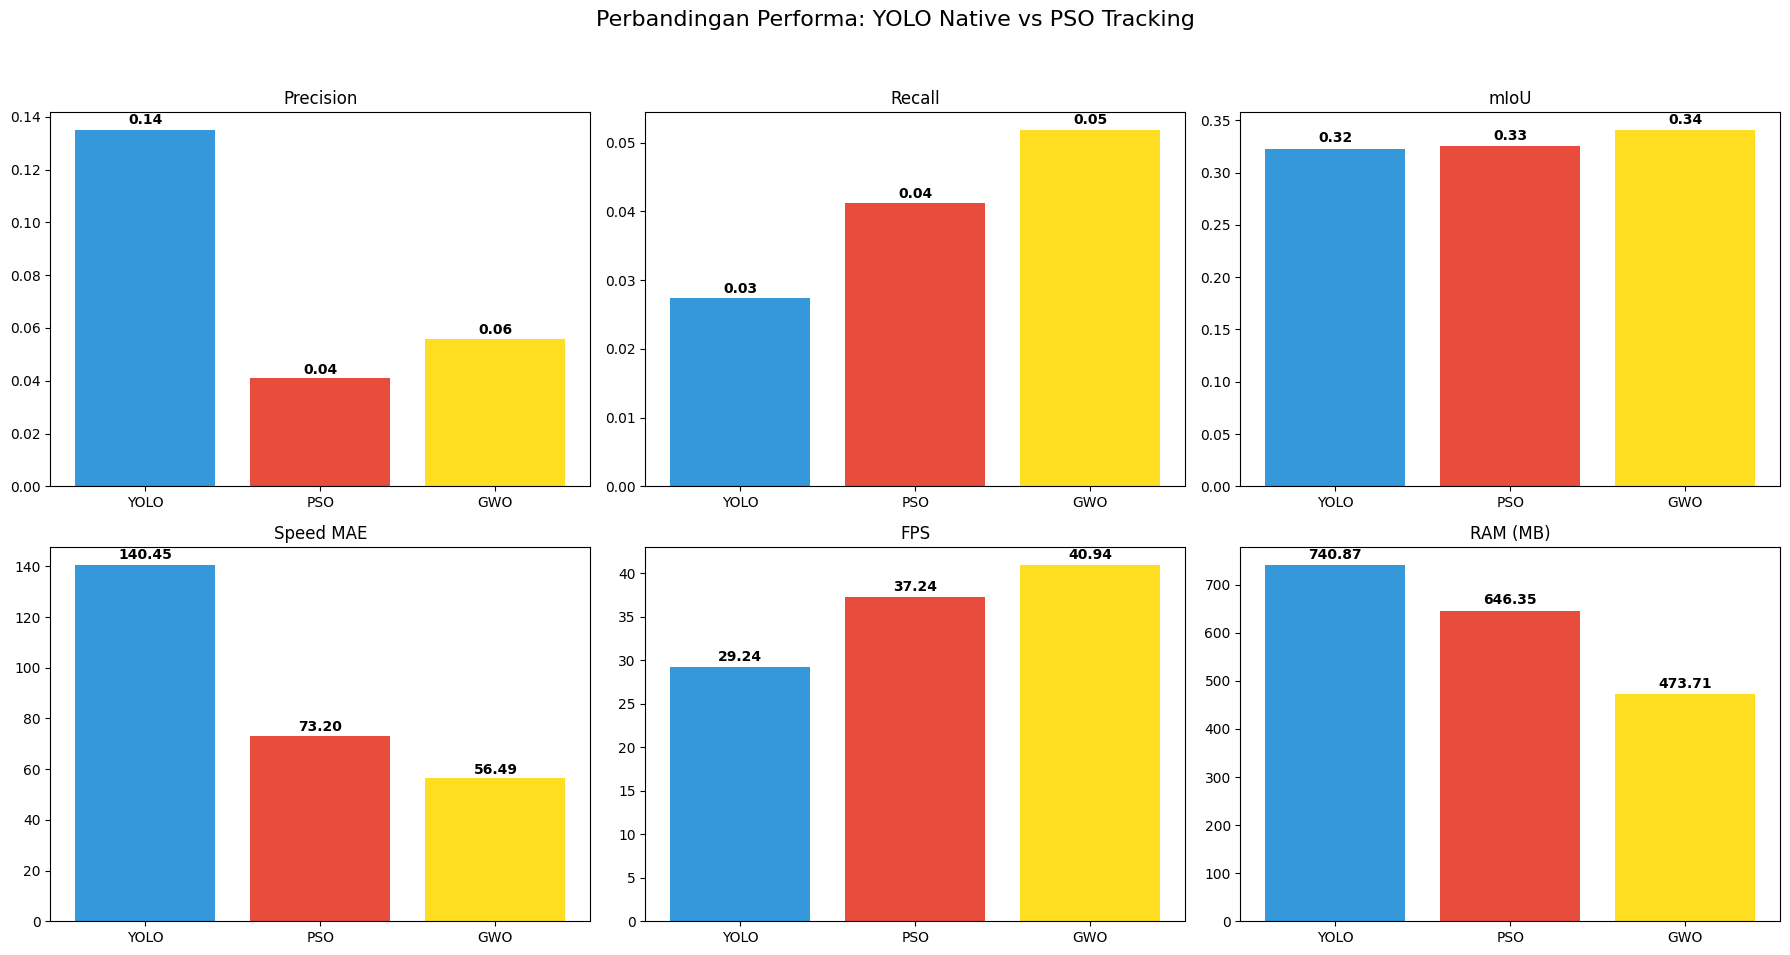


Grafik tersimpan sebagai 'grafik_perbandingan_final.png'


In [33]:
# ==========================================
# 1. KONFIGURASI FILE (PASTIKAN FILE ADA)
# ==========================================
GT_FILE = "ground_truth_speed_only.csv"

# File YOLO Native
PRED_YOLO = "predictions_yolo.csv"
PERF_YOLO = "performance_log.csv" # Pastikan ini hasil run batch yolo

# File PSO Tracking
PRED_PSO  = "predictions_pso.csv"
PERF_PSO  = "performance_log_pso.csv" # Pastikan ini hasil run batch pso

PRED_GWO  = "predictions_gwo.csv"
PERF_GWO  = "performance_log_gwo.csv" # Pastikan ini hasil run batch pso

IOU_THRESHOLD = 0.25

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def calculate_iou(boxA, boxB):
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    return interArea / float(boxAArea + boxBArea - interArea)

def load_csv_data(filepath):
    data = {}
    if not os.path.exists(filepath): return {}
    with open(filepath, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            if len(row) < 7: continue
            vid, frame = row[0], int(row[1])
            box = list(map(int, row[2:6]))
            label = row[6]
            speed = float(row[7]) if len(row) > 7 else 0.0
            
            if vid not in data: data[vid] = {}
            if frame not in data[vid]: data[vid][frame] = []
            data[vid][frame].append({'box': box, 'label': label, 'speed': speed})
    return data

def load_performance_stats(filepath):
    """Menghitung rata-rata FPS dan RAM dari file log"""
    if not os.path.exists(filepath): return 0, 0
    fps_list, ram_list = [], []
    with open(filepath, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            if len(row) < 3: continue
            # row: [video, avg_fps, max_ram, time]
            fps_list.append(float(row[1]))
            ram_list.append(float(row[2]))
    return np.mean(fps_list), np.mean(ram_list)

# ==========================================
# 3. CORE EVALUATION LOGIC
# ==========================================
def evaluate_model(pred_file, perf_file, gt_data):
    if not os.path.exists(pred_file):
        print(f"File prediksi tidak ditemukan: {pred_file}")
        return None

    pred_data = load_csv_data(pred_file)
    
    tp, fp, fn = 0, 0, 0
    speed_errs, ious = [], []
    
    for vid in gt_data:
        for frm in gt_data[vid]:
            gt_objs = gt_data[vid][frm]
            pr_objs = pred_data.get(vid, {}).get(frm, [])
            matched = set()
            
            for gt_obj in gt_objs:
                best_iou, best_idx = 0, -1
                for i, p in enumerate(pr_objs):
                    if i in matched: continue
                    iou = calculate_iou(gt_obj['box'], p['box'])
                    if iou > best_iou: best_iou, best_idx = iou, i
                
                if best_iou >= IOU_THRESHOLD:
                    tp += 1
                    ious.append(best_iou)
                    matched.add(best_idx)
                    speed_errs.append(abs(pr_objs[best_idx]['speed'] - gt_obj['speed']))
                else:
                    fn += 1
            fp += len(pr_objs) - len(matched)
            
    # Load Performance
    avg_fps, avg_ram = load_performance_stats(perf_file)
    
    return {
        "Precision": tp/(tp+fp) if (tp+fp)>0 else 0,
        "Recall": tp/(tp+fn) if (tp+fn)>0 else 0,
        "F1-Score": 2*(tp/(tp+fp) * tp/(tp+fn)) / (tp/(tp+fp) + tp/(tp+fn)) if tp>0 else 0,
        "mIoU": np.mean(ious) if ious else 0,
        "Speed MAE": np.mean(speed_errs) if speed_errs else 0,
        "FPS": avg_fps,
        "RAM (MB)": avg_ram
    }

# ==========================================
# 4. MAIN & VISUALIZATION
# ==========================================
def main():
    print("=== FINAL COMPARISON: ===")
    gt_data = load_csv_data(GT_FILE)
    
    # Hitung Metrik
    res_yolo = evaluate_model(PRED_YOLO, PERF_YOLO, gt_data)
    res_pso = evaluate_model(PRED_PSO, PERF_PSO, gt_data)
    res_gwo = evaluate_model(PRED_GWO, PERF_GWO, gt_data)
    
    if not res_yolo or not res_pso:
        print("Gagal memuat salah satu file prediksi.")
        return

    # Buat DataFrame
    df = pd.DataFrame({
        'YOLO Native': res_yolo,
        'PSO Tracking': res_pso,
        'GWO Tracking': res_gwo
    })
    
    print("\n--- TABEL HASIL ---")
    print(df)
    df.to_csv("final_report_comparison.csv")
    
    # --- PLOTTING ---
    metrics = ['Precision', 'Recall', 'mIoU', 'Speed MAE', 'FPS', 'RAM (MB)']
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Perbandingan Performa: YOLO Native vs PSO Tracking', fontsize=16)
    
    colors = ['#3498db', '#e74c3c', '#FFDE21'] # Biru=Yolo, Merah=PSO, kuning=GWO
    
    # Loop untuk membuat 6 grafik
    for i, metric in enumerate(metrics):
        row, col = i // 3, i % 3
        ax = axes[row, col]
        
        val_yolo = res_yolo[metric]
        val_pso = res_pso[metric]
        val_gwo = res_gwo[metric]
        
        bars = ax.bar(['YOLO', 'PSO', 'GWO'], [val_yolo, val_pso, val_gwo], color=colors)
        ax.set_title(metric)
        
        # Labeling
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., 1.01*height,
                    f'{height:.2f}', ha='center', va='bottom', fontweight='bold')
            
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("grafik_perbandingan_final.png")
    plt.show()
    print("\nGrafik tersimpan sebagai 'grafik_perbandingan_final.png'")

if __name__ == "__main__":
    main()

## DEMO

In [ ]:
# ==========================================
# KONFIGURASI SINGLE RUN
# ==========================================
TARGET_VIDEO_NAME = "std_VID_20251201_161627.mp4" 
VIDEO_PATH_FULL = os.path.join(VIDEO_FOLDER, TARGET_VIDEO_NAME)
MODEL_PATH = r"FP_Training/YOLOv8n_Tuned_Final2/weights/best.pt"

# Parameter Umum
TARGET_WIDTH = 1080 
CONF_THRESHOLD = 0.25    
HELMET_DIST_THRESHOLD = 250 
SPEED_MIN_THRESHOLD = 2.0 
PIXELS_PER_METER = 20  
FPS_CAMERA = 30        

# ==========================================
# FUNGSI 1: YOLO NATIVE RUNNER
# ==========================================
def run_single_yolo():
    print(f"\n>>> 1. PLAYING: YOLO NATIVE")
    print("Tekan 'q' untuk skip ke PSO...")
    
    cap = cv2.VideoCapture(VIDEO_PATH_FULL)
    model = YOLO(MODEL_PATH)
    track_history = {}
    
    while True:
        ret, frame = cap.read()
        if not ret: break
        frame = cv2.resize(frame, (1280, 720))
        results = model.track(frame, persist=True, conf=CONF_THRESHOLD, verbose=False)[0]
        
        if results.boxes.id is not None:
            boxes = results.boxes.xyxy.cpu().numpy().astype(int)
            ids = results.boxes.id.cpu().numpy().astype(int)
            clss = results.boxes.cls.cpu().numpy().astype(int)
            
            for box, track_id, cls in zip(boxes, ids, clss):
                if model.names[cls] in ['Motor', 'motorcycle', 'motorbike']:
                    # Cek Helm
                    status_txt, head_box = get_helmet_info(box, results.boxes, model.names)
                    
                    # Merge Box
                    x1, y1, x2, y2 = box
                    if head_box:
                        hx1, hy1, hx2, hy2 = head_box
                        x1, y1, x2, y2 = min(x1, hx1), min(y1, hy1), max(x2, hx2), max(y2, hy2)
                    
                    # Speed
                    curr = ((x1+x2)//2, (y1+y2)//2)
                    spd = 0
                    if track_id in track_history:
                        d = math.dist(track_history[track_id], curr)
                        if d > SPEED_MIN_THRESHOLD: spd = d
                    track_history[track_id] = curr
                    
                    kmh = (spd * FPS_CAMERA / PIXELS_PER_METER) * 3.6
                    col = (0, 255, 0) if "PAKAI" in status_txt else (0, 0, 255)
                    cv2.rectangle(frame, (x1, y1), (x2, y2), col, 2)
                    cv2.putText(frame, f"YOLO:{track_id} {status_txt}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, col, 2)
                    cv2.putText(frame, f"{kmh:.1f} km/h", (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

        cv2.putText(frame, "MODE: YOLO NATIVE", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
        cv2.imshow("Single Video Test", resize_display(frame))
        if cv2.waitKey(30) & 0xFF == ord('q'): break

    cap.release()

# ==========================================
# FUNGSI 2: PSO RUNNER
# ==========================================
def run_single_pso():
    print(f"\n>>> 2. PLAYING: PSO TRACKING")
    print("Tekan 'q' untuk skip ke GWO...")
    
    cap = cv2.VideoCapture(VIDEO_PATH_FULL)
    model = YOLO(MODEL_PATH)
    trackers = []
    next_id = 1
    
    while True:
        ret, frame = cap.read()
        if not ret: break
        frame = cv2.resize(frame, (1280, 720))
        
        # YOLO Detect
        results = model(frame, conf=CONF_THRESHOLD, verbose=False)[0]
        dets = []
        for r in results.boxes:
            if model.names[int(r.cls[0])] in ['Motor', 'motorcycle', 'motorbike']:
                dets.append(tuple(map(int, r.xyxy[0])))
        
        # Match & Update (PSO)
        matches, unmatched, used = match_detections_to_trackers(dets, trackers)
        
        for t, d in matches:
            trackers[t].update(frame, dets[d])
            s, _ = get_helmet_info(dets[d], results.boxes, model.names)
            if s != "Unknown": trackers[t].helmet_status = s
            
        for i in range(len(trackers)):
            if i not in used: trackers[i].update(frame, None)
            
        for d in unmatched:
            nt = MotorTracker(next_id, dets[d], frame) # Pake class PSO
            s, _ = get_helmet_info(dets[d], results.boxes, model.names)
            nt.helmet_status = s
            trackers.append(nt)
            next_id += 1
            
        trackers = [t for t in trackers if t.missing_frames < 30]

        # Visualisasi
        for t in trackers:
            kmh = (t.speed_px * FPS_CAMERA / PIXELS_PER_METER) * 3.6
            col = (0, 255, 0) if "PAKAI" in t.helmet_status else (0, 0, 255)
            x1, y1, x2, y2 = map(int, t.bbox)
            cv2.rectangle(frame, (x1, y1), (x2, y2), col, 2)
            cv2.putText(frame, f"PSO:{t.id} {t.helmet_status}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, col, 2)
            cv2.putText(frame, f"{kmh:.1f} km/h", (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

        cv2.putText(frame, "MODE: PSO TRACKING", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow("Single Video Test", resize_display(frame))
        if cv2.waitKey(30) & 0xFF == ord('q'): break

    cap.release()

# ==========================================
# FUNGSI 3: GWO RUNNER
# ==========================================
def run_single_gwo():
    print(f"\n>>> 3. PLAYING: GWO TRACKING")
    print("Tekan 'q' untuk Selesai...")
    
    cap = cv2.VideoCapture(VIDEO_PATH_FULL)
    model = YOLO(MODEL_PATH)
    trackers = []
    next_id = 1
    
    while True:
        ret, frame = cap.read()
        if not ret: break
        frame = cv2.resize(frame, (1280, 720))
        
        # YOLO Detect
        results = model(frame, conf=CONF_THRESHOLD, verbose=False)[0]
        dets = []
        for r in results.boxes:
            if model.names[int(r.cls[0])] in ['Motor', 'motorcycle', 'motorbike']:
                dets.append(tuple(map(int, r.xyxy[0])))
        
        # Match & Update (GWO)
        matches, unmatched, used = match_detections_to_trackers(dets, trackers)
        
        for t, d in matches:
            trackers[t].update(frame, dets[d])
            s, _ = get_helmet_info(dets[d], results.boxes, model.names)
            if s != "Unknown": trackers[t].helmet_status = s
            
        for i in range(len(trackers)):
            if i not in used: trackers[i].update(frame, None)
            
        for d in unmatched:
            nt = MotorTrackerGWO(next_id, dets[d], frame) # Pake class GWO
            s, _ = get_helmet_info(dets[d], results.boxes, model.names)
            nt.helmet_status = s
            trackers.append(nt)
            next_id += 1
            
        trackers = [t for t in trackers if t.miss < 30]

        # Visualisasi
        for t in trackers:
            kmh = (t.speed_px * FPS_CAMERA / PIXELS_PER_METER) * 3.6
            col = (0, 255, 0) if "PAKAI" in t.helmet_status else (0, 0, 255)
            x1, y1, x2, y2 = map(int, t.bbox)
            cv2.rectangle(frame, (x1, y1), (x2, y2), col, 2)
            cv2.putText(frame, f"GWO:{t.id} {t.helmet_status}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, col, 2)
            cv2.putText(frame, f"{kmh:.1f} km/h", (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

        cv2.putText(frame, "MODE: GWO TRACKING", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow("Single Video Test", resize_display(frame))
        if cv2.waitKey(30) & 0xFF == ord('q'): break

    cap.release()

# ==========================================
# MAIN EXECUTION
# ==========================================
if not os.path.exists(VIDEO_PATH_FULL):
    print(f"Error: Video {TARGET_VIDEO_NAME} tidak ditemukan!")
else:
    run_single_yolo()
    time.sleep(1)
    run_single_pso()
    time.sleep(1)
    run_single_gwo()
    
    cv2.destroyAllWindows()
    print("\n✅ Demo Selesai!")


>>> 1. PLAYING: YOLO NATIVE
Tekan 'q' untuk skip ke PSO...

>>> 2. PLAYING: PSO TRACKING
Tekan 'q' untuk skip ke GWO...

>>> 3. PLAYING: GWO TRACKING
Tekan 'q' untuk Selesai...

✅ Demo Selesai!
